In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees


In [19]:
corr = 0.

# Load Model

In [20]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_initseed4_batch512"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=17-val_loss=0.000553.ckpt


In [21]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [22]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_3072034/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [23]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


# Helper Functions

In [24]:
def format_transformer_input_from_batch(batch, model):
    query_states = batch['query_states'][:, None, :]
    zeros = batch['zeros'][:, None, :]
    state_seq = torch.cat([batch['context_states'], query_states], dim=1)
    action_seq = torch.cat(
        [batch['context_actions'], zeros[:, :, :model.action_dim]], dim=1)
    next_state_seq = torch.cat(
        [batch['context_next_states'], zeros[:, :, :model.state_dim]], dim=1)
    reward_seq = torch.cat([batch['context_rewards'], zeros[:, :, :1]], dim=1)
    seq = torch.cat(
        [state_seq, action_seq, next_state_seq, reward_seq], dim=2)
    seq_len = seq.shape[1]
    stacked_inputs = model.embed_transition(seq)
    return stacked_inputs

In [25]:
def format_batches(traj, context_length=1000):
    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'][:context_length])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'][:context_length])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'][:context_length])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'][:context_length])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),
        } 
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k]
        batch[k] = batch[k].to(model.device)
    baseline_batch = {}
    for k, v in batch.items():
        baseline_batch[k] = v.clone() if isinstance(v, torch.Tensor) else v
    baseline_batch['context_actions'] *= 0
    baseline_batch['context_actions'] += 0.25
    return baseline_batch, batch

In [26]:
def aggregate_token_attributions(attributions, aggregation_method='l2'):
    """
    Aggregate attributions across embedding dimensions to get token-level scores.
    
    Args:
        attributions: Attribution tensor of shape [seq_len, emb_dim]
        aggregation_method: Method to aggregate across embedding dimensions ('sum', 'l2', 'mean')
        
    Returns:
        Tensor of token-level attributions of shape [seq_len]
    """
    if aggregation_method == 'sum':
        return torch.sum(attributions, dim=-1)
    elif aggregation_method == 'l2':
        return torch.sqrt(torch.sum(attributions ** 2, dim=-1))
    elif aggregation_method == 'mean':
        return torch.mean(attributions, dim=-1)
    elif aggregation_method == 'sum-abs':
        return torch.sum(torch.abs(attributions), dim=-1)
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

# Run Gradient Attribution

In [27]:
def get_output_attributions(traj, model):
    baseline_batch, batch = format_batches(traj)
    layer_attributions = {}
    inputs = format_transformer_input_from_batch(batch, model)
    baseline_inputs = format_transformer_input_from_batch(baseline_batch, model)

    # Output w.r.t Input
    alphas = torch.linspace(0, 1, steps=20)
    all_grads = []
    for alpha in alphas:
        interp_input = alpha*inputs + (1-alpha)*baseline_inputs
        interp_input.requires_grad_(True)

        # Forward pass to get layer output
        transformer_output = model.transformer(inputs_embeds=interp_input)
        preds = model.pred_actions(transformer_output['last_hidden_state'])
        preds = preds[:, -1, :]
        target = preds[:, traj['optimal_action'].argmax()]

        grad_wrt_input = torch.autograd.grad(
            outputs=target,
            inputs=interp_input,
            grad_outputs=target,
            retain_graph=True
        )[0]
        all_grads.append(grad_wrt_input)
    avg_grad = torch.stack(all_grads).mean(dim=0)
    avg_grad = avg_grad.detach().cpu().numpy().squeeze()
    delta_input = (inputs - baseline_inputs).detach().cpu().numpy().squeeze()
    input_to_output_attribution = np.sum(avg_grad * delta_input, axis=1)
    return input_to_output_attribution

In [28]:
def get_states_on_path(query_state, env, optimal_action_map):
    opt_act = -1
    curr_state = query_state
    states_on_path = []
    while opt_act != 3:
        states_on_path.append(curr_state)
        opt_act = optimal_action_map[tuple(curr_state)]
        act_vector = np.zeros(4)
        act_vector[opt_act] = 1
        curr_state = env.transit(curr_state, act_vector)[0]
    return states_on_path


In [29]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

In [30]:
def get_layer1_parent(node):
    if node.layer == 1:
        return node.encoding()
    else:
        return get_layer1_parent(node.parent)

In [31]:
results = {
    'grad_val': [],
    'node_dist_from_goal': [],
    'query_dist_from_goal': [],
    'query_is_same_quarter_as_goal': [],
}
results_B = {
    'grad_val': [],
    'node_is_same_quarter_as_goal': [],
    'node_dist_from_goal': [],
    'query_is_same_quarter_as_goal': [],
    'query_dist_from_goal': [],
}
n_iters = 2

for i_eval in range(n_eval_envs):
    traj = eval_trajs[i_eval]
    first_reward_idx = np.where(traj['context_rewards'] != 0)[0]
    if (first_reward_idx.size == 0) or (first_reward_idx[0] > 800):
        continue
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding_corr': corr,
        'state_dim': state_dim,
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
    optimal_action_map, dist_from_goal = env.make_opt_action_dict()
    for query_dist_from_goal in range(1, 13):
        for _ in range(n_iters):
            valid_query_states = []
            for i in range(len(traj['context_states'])):
                if traj['context_states'][i].tolist() == list(env.root.encoding()):
                    continue
                d = dist_from_goal[tuple(traj['context_states'][i].tolist())]
                if d != query_dist_from_goal:
                    continue
                valid_query_states.append(traj['context_states'][i])
            if len(valid_query_states) == 0:
                continue
            traj['query_state'] = valid_query_states[np.random.choice(len(valid_query_states))]
            query_state = traj['query_state'].tolist()
            goal_state = traj['goal'].tolist()
            query_layer = env.node_map[tuple(query_state)].layer
            query_pos = env.node_map[tuple(query_state)].pos
            goal_layer = env.node_map[tuple(goal_state)].layer
            goal_pos = env.node_map[tuple(goal_state)].pos
            root_state = list(env.root.encoding())
            layer1_parent_state = list(get_layer1_parent(env.node_map[tuple(query_state)]))
            same_quarter_as_goal = get_subtree_location(query_layer, query_pos, 'quarter') == get_subtree_location(goal_layer, goal_pos, 'quarter')
            states_on_path = get_states_on_path(query_state, env, optimal_action_map)
            attentions = get_output_attributions(traj, model)
            max_scale = np.abs(attentions).max()
            attentions = attentions/max_scale
    
            for idx, attn in enumerate(attentions):
                curr_state = traj['context_states'][idx].tolist()
                next_state = traj['context_next_states'][idx].tolist()
                if curr_state == next_state:
                    continue
                curr_state_layer = env.node_map[tuple(curr_state)].layer
                curr_state_pos = env.node_map[tuple(curr_state)].pos
                next_state_layer = env.node_map[tuple(next_state)].layer
                next_state_pos = env.node_map[tuple(next_state)].pos
                curr_state_is_same_quarter_as_goal = \
                    get_subtree_location(curr_state_layer, curr_state_pos, 'quarter') == get_subtree_location(goal_layer, goal_pos, 'quarter') or \
                    curr_state == root_state or \
                    curr_state == layer1_parent_state
                next_state_is_same_quarter_as_goal = \
                    get_subtree_location(next_state_layer, next_state_pos, 'quarter') == get_subtree_location(goal_layer, goal_pos, 'quarter') or \
                    next_state == root_state or \
                    next_state == layer1_parent_state
                results_B['grad_val'].append(attn)
                results_B['node_is_same_quarter_as_goal'].append(curr_state_is_same_quarter_as_goal or next_state_is_same_quarter_as_goal)
                results_B['node_dist_from_goal'].append(np.mean([dist_from_goal[tuple(curr_state)], dist_from_goal[tuple(next_state)]]))
                results_B['query_is_same_quarter_as_goal'].append(same_quarter_as_goal)
                results_B['query_dist_from_goal'].append(query_dist_from_goal)
                if curr_state in states_on_path and next_state in states_on_path:
                    results['node_dist_from_goal'].append(np.mean([dist_from_goal[tuple(curr_state)], dist_from_goal[tuple(next_state)]]))
                    results['query_dist_from_goal'].append(query_dist_from_goal)
                    results['grad_val'].append(attn)
                    results['query_is_same_quarter_as_goal'].append(same_quarter_as_goal)

# Visualize

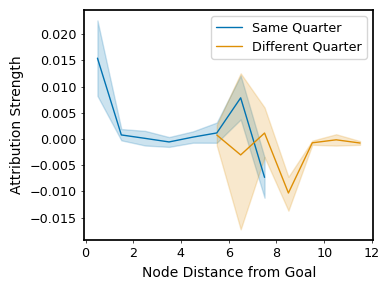

In [32]:
df = pd.DataFrame(results_B)
df = df[df['query_dist_from_goal'] >= 6]
df = df[df['query_dist_from_goal'] <= 8]
df = df[df['query_is_same_quarter_as_goal']==False]
df_quarter_true = df[df['node_is_same_quarter_as_goal']==True]
df_quarter_false = df[df['node_is_same_quarter_as_goal']==False]
fig, ax = plt.subplots(figsize=(4, 3))
sns.lineplot(data=df_quarter_true, x='node_dist_from_goal', y='grad_val', ax=ax, label='Same Quarter')
sns.lineplot(data=df_quarter_false, x='node_dist_from_goal', y='grad_val', ax=ax, label='Different Quarter')
ax.set_xlabel('Node Distance from Goal')
ax.set_ylabel('Attribution Strength')
plt.tight_layout()
plt.show()


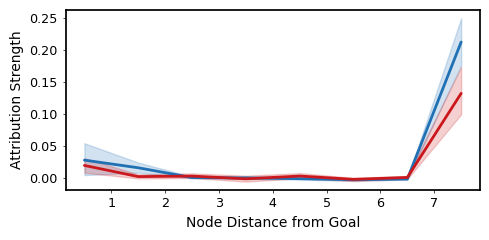

In [33]:
df = pd.DataFrame(results)
df = df[df['query_dist_from_goal'] == 8]
plt.figure(figsize=(5, 2.5))
# Create a custom palette using a subset of the Blues colormap
n_colors = len(df['query_dist_from_goal'].unique())
custom_blues = sns.color_palette("Blues", n_colors=n_colors*2+1)[2::2] # Skip the lightest colors
custom_reds = sns.color_palette("Reds", n_colors=n_colors*2+1)[2::2] # Skip the lightest colors

sns.lineplot(
    data=df[df['query_is_same_quarter_as_goal']==True], x='node_dist_from_goal', y='grad_val', hue='query_dist_from_goal',
    legend=False, linewidth=2, palette=custom_blues
)
sns.lineplot(
    data=df[df['query_is_same_quarter_as_goal']==False], x='node_dist_from_goal', y='grad_val', hue='query_dist_from_goal',
    legend=False, linewidth=2, palette=custom_reds
)
plt.xlabel('Node Distance from Goal')
plt.ylabel('Attribution Strength')
plt.tight_layout()
plt.show()


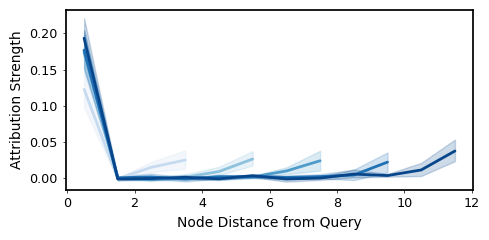

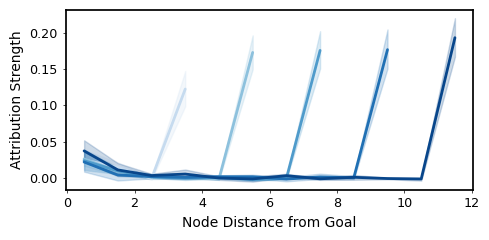

In [34]:
df = pd.DataFrame(results)
df = df[df['query_dist_from_goal'] > 2]
df = df[df['query_dist_from_goal'] % 2 == 0]
df['node_dist_from_query'] = df['query_dist_from_goal'] - df['node_dist_from_goal']
plt.figure(figsize=(5, 2.5))
# Create a custom palette using a subset of the Blues colormap
n_colors = len(df['query_dist_from_goal'].unique())
custom_blues = sns.color_palette("Blues", n_colors=n_colors*2+1)[2::2] # Skip the lightest colors

sns.lineplot(
    data=df, x='node_dist_from_query', y='grad_val', hue='query_dist_from_goal',
    legend=False, linewidth=2, palette=custom_blues
)
plt.xlabel('Node Distance from Query')
plt.ylabel('Attribution Strength')
plt.tight_layout()
plt.show()

df = pd.DataFrame(results)
df = df[df['query_dist_from_goal'] > 2]
df = df[df['query_dist_from_goal'] % 2 == 0]
df['node_dist_from_query'] = df['query_dist_from_goal'] - df['node_dist_from_goal']
plt.figure(figsize=(5, 2.5))
# Create a custom palette using a subset of the Blues colormap
n_colors = len(df['query_dist_from_goal'].unique())
custom_blues = sns.color_palette("Blues", n_colors=n_colors*2+1)[2::2] # Skip the lightest colors

sns.lineplot(
    data=df, x='node_dist_from_goal', y='grad_val', hue='query_dist_from_goal',
    legend=False, linewidth=2, palette=custom_blues
)
plt.xlabel('Node Distance from Goal')
plt.ylabel('Attribution Strength')
plt.tight_layout()
plt.show()

